This notebook consist of Basic Exploratory data analysis and Modelling Techniques I had used to secure a rank under 20.
My rank was 14th out of around 7400 participants

Here is the link of leaderboard --https://www.hackerearth.com/challenges/competitive/airplane-accident-severity-hackerearth-machine-learning-challenge/leaderboard/how-severe-can-an-airplane-accident-be-03e7a3f1/page/149/


In [31]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import math

%matplotlib inline


plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold,TimeSeriesSplit,cross_val_score



# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier

import xgboost as xgb
import lightgbm as lgb
#!pip3 install catboost
import catboost as cat

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer



In [32]:
train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")
sample=pd.read_csv("data/sample_submission.csv")
data = pd.concat([train, test], ignore_index=True)

print("Train Shape : {}\nTest Shape: {}".format(train.shape, test.shape))

Train Shape : (10000, 12)
Test Shape: (2500, 11)


In [33]:
train.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [34]:
train.Severity.value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

#### All dataset is numeric there is no categorical feature except Accident_Type_Code

In [35]:
train["Severity"].value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

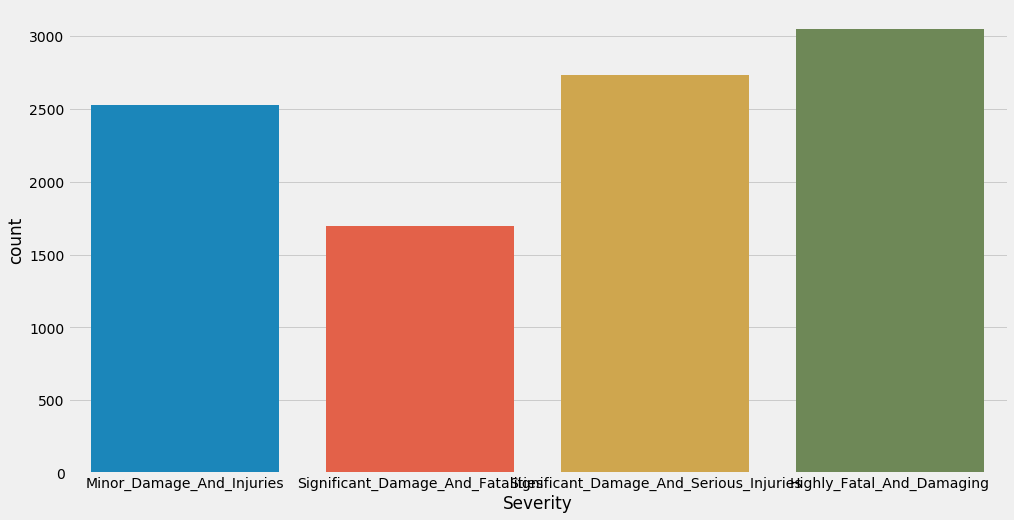

In [36]:
sns.countplot(train["Severity"])
plt.show()

##### Seems to balanced dataset as all class having equal probability.

In [37]:
# Check for null values
train.isnull().sum()

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [38]:
train.describe()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,41.876406,12.931100,6.564300,65.145324,0.381495,79.969331,3.814900,32001.803282,2.01220,0.255635,6266.554200
std,16.138072,3.539803,6.971982,11.882934,0.121301,2.759739,1.902577,9431.995196,1.03998,0.381128,3610.170288
min,0.000000,1.000000,0.000000,0.000000,0.134000,74.740000,1.000000,831.695553,0.00000,0.000316,2.000000
25%,30.593607,11.000000,2.000000,56.927985,0.293665,77.960000,2.000000,25757.636908,1.00000,0.012063,3139.750000
50%,41.278539,13.000000,4.000000,65.587967,0.365879,79.540000,4.000000,32060.336419,2.00000,0.074467,6280.500000
75%,52.511416,15.000000,9.000000,73.336372,0.451346,81.560000,5.000000,38380.641513,3.00000,0.354059,9391.500000
max,100.000000,23.000000,54.000000,100.000000,0.882648,97.510000,7.000000,64297.651218,5.00000,2.365378,12500.000000


In [39]:
train["Severity"]

0                     Minor_Damage_And_Injuries
1                     Minor_Damage_And_Injuries
2             Significant_Damage_And_Fatalities
3       Significant_Damage_And_Serious_Injuries
4             Significant_Damage_And_Fatalities
                         ...                   
9995    Significant_Damage_And_Serious_Injuries
9996                  Highly_Fatal_And_Damaging
9997    Significant_Damage_And_Serious_Injuries
9998                  Minor_Damage_And_Injuries
9999                  Highly_Fatal_And_Damaging
Name: Severity, Length: 10000, dtype: object

In [40]:
encode = LabelEncoder()
train.Severity = encode.fit_transform(train.Severity)

In [41]:
train.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,1,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,1,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,2,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,3,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,2,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


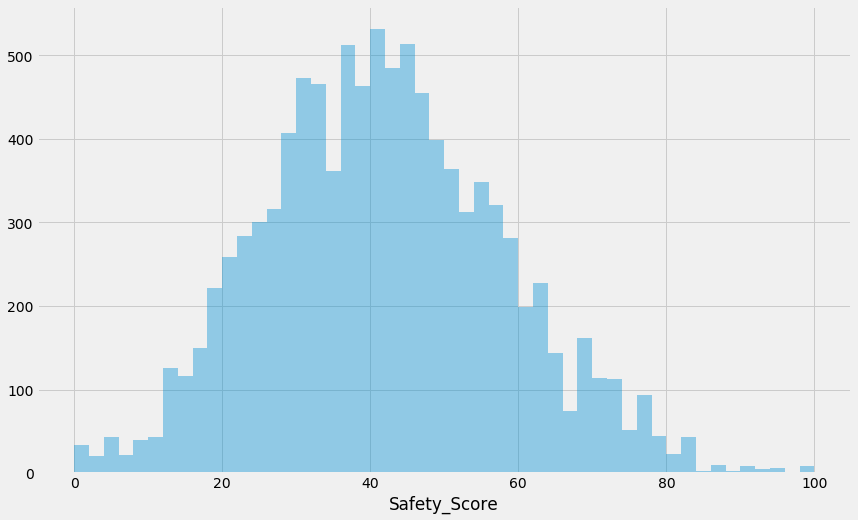

In [42]:
plt.figure(figsize=(13,8))
sns.distplot(train['Safety_Score'], kde=False)
plt.show()

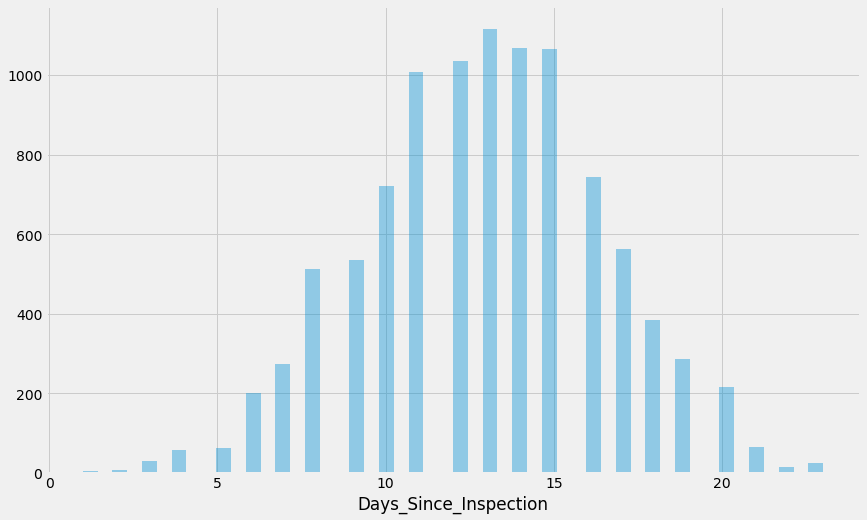

In [43]:
plt.figure(figsize=(13,8))
sns.distplot(train['Days_Since_Inspection'], kde=False)
plt.show()

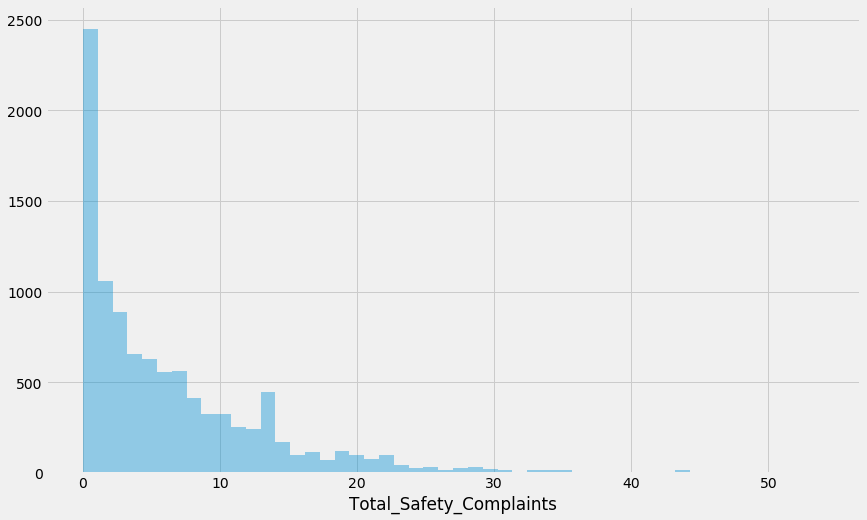

In [44]:
plt.figure(figsize=(13,8))
sns.distplot(train['Total_Safety_Complaints'], kde=False)
plt.show()

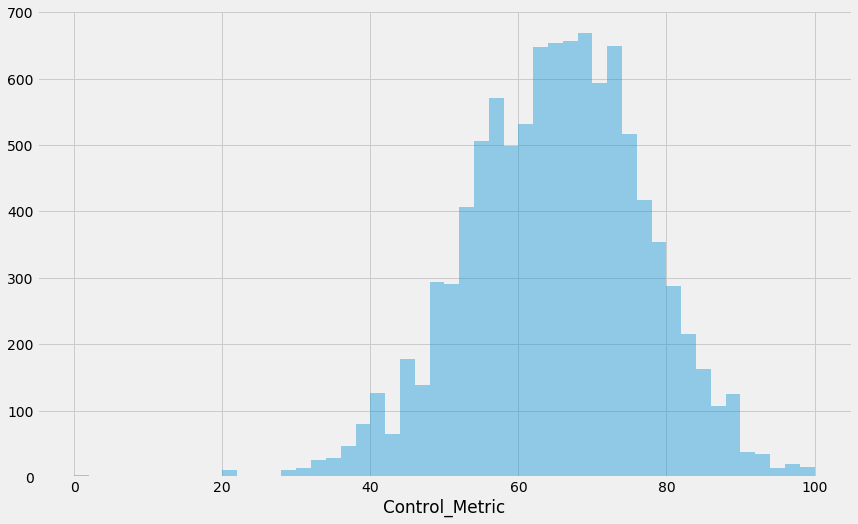

In [45]:
plt.figure(figsize=(13,8))
sns.distplot(train['Control_Metric'], kde=False)
plt.show()

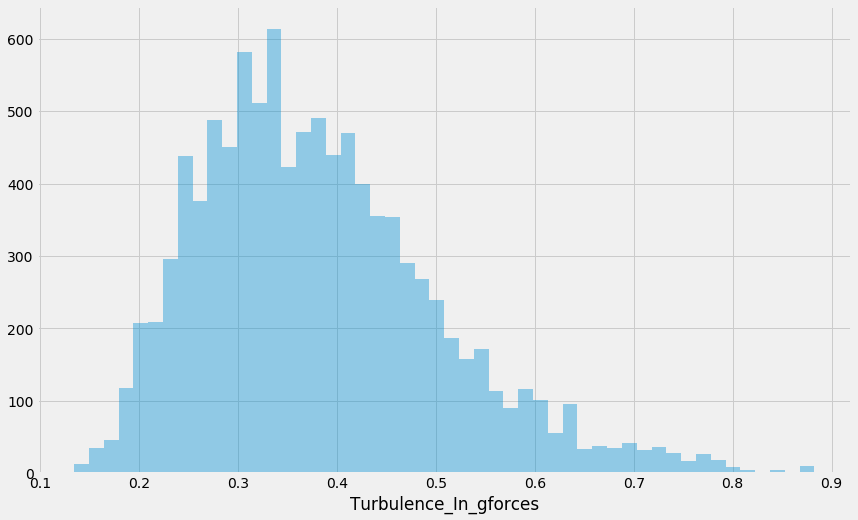

In [46]:
plt.figure(figsize=(13,8))
sns.distplot(train['Turbulence_In_gforces'], kde=False)
plt.show()

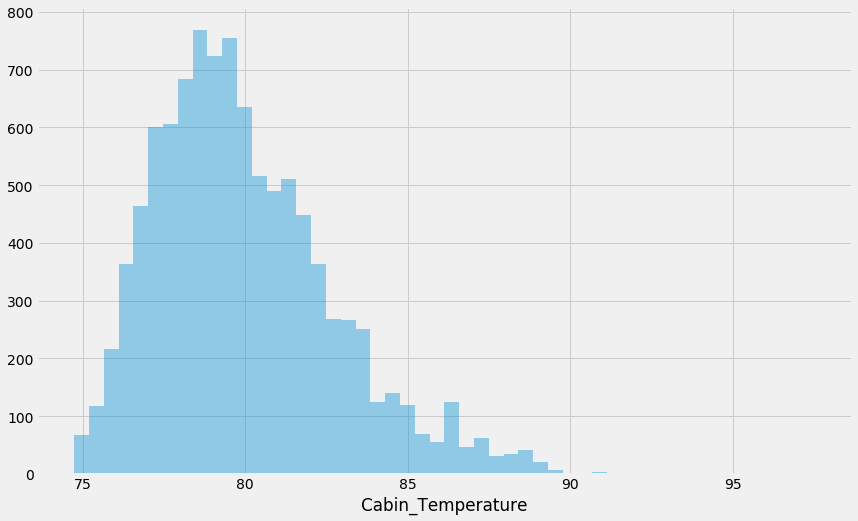

In [47]:
plt.figure(figsize=(13,8))
sns.distplot(train['Cabin_Temperature'], kde=False)
plt.show()

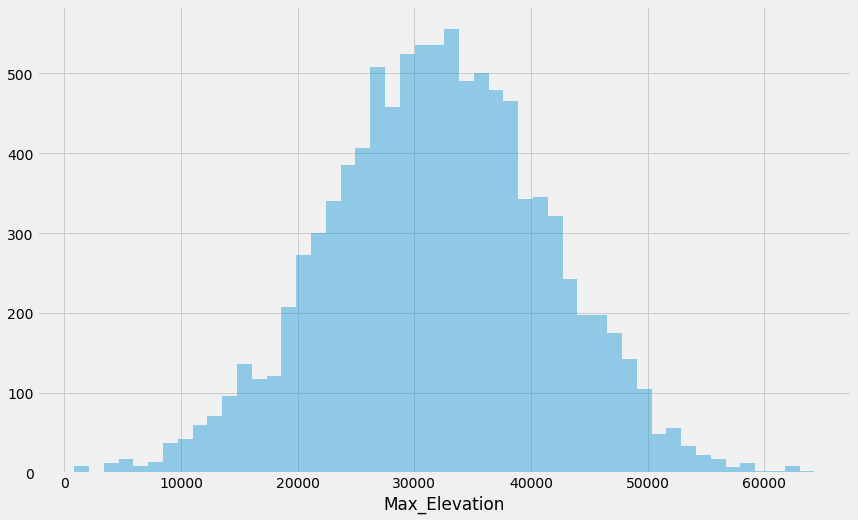

In [48]:
plt.figure(figsize=(13,8))
sns.distplot(train['Max_Elevation'], kde=False)
plt.show()

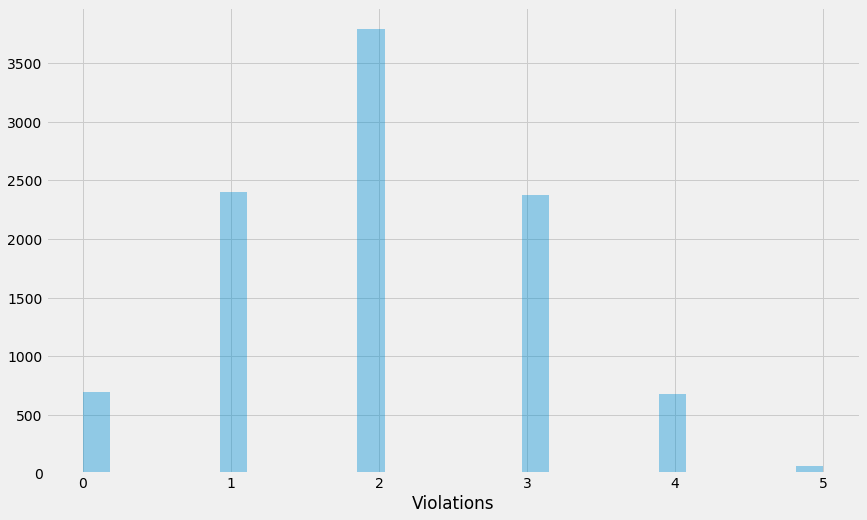

In [49]:
plt.figure(figsize=(13,8))
sns.distplot(train['Violations'], kde=False)
plt.show()

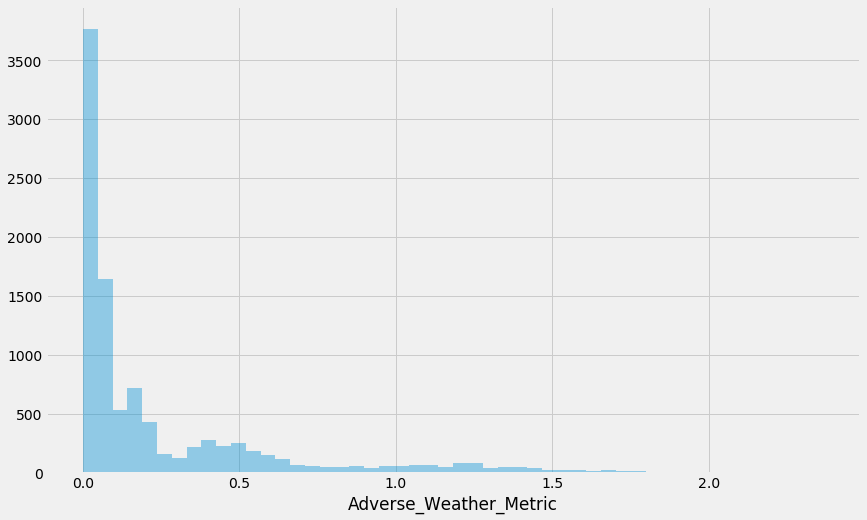

In [50]:
plt.figure(figsize=(13,8))
sns.distplot(train['Adverse_Weather_Metric'], kde=False)
plt.show()

In [51]:
data.head()

,Accident_ID,Accident_Type_Code,Adverse_Weather_Metric,Cabin_Temperature,Control_Metric,Days_Since_Inspection,Max_Elevation,Safety_Score,Severity,Total_Safety_Complaints,Turbulence_In_gforces,Violations
0,7570,2,0.424352,78.04,71.285324,14,31335.476824,49.223744,Minor_Damage_And_Injuries,22,0.272118,3
1,12128,2,0.352350,84.54,72.288058,10,26024.711057,62.465753,Minor_Damage_And_Injuries,27,0.423939,2
2,2181,7,0.003364,78.86,66.362808,13,39269.053927,63.059361,Significant_Damage_And_Fatalities,16,0.322604,3
3,5946,3,0.211728,81.79,74.703737,11,42771.499200,48.082192,Significant_Damage_And_Serious_Injuries,9,0.337029,1
4,9054,3,0.176883,77.16,47.948952,13,35509.228515,26.484018,Significant_Damage_And_Fatalities,25,0.541140,2


In [52]:
test.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


test["Safety_Score"]=1/(test["Safety_Score"]+0.0000001)
test["Control_Metric"]=1/(test["Control_Metric"]+0.000001)
train["Safety_Score"]=1/(train["Safety_Score"]+0.0000001)
train["Control_Metric"]=1/(train["Control_Metric"]+0.000001)
#data["Adverse_Weather_Metric"]=1/data["Adverse_Weather_Metric"]

train.loc[train.Safety_Score > 100,'Safety_Score']=100 
train.loc[train.Control_Metric > 100,'Control_Metric']=100 
test.loc[test.Safety_Score > 100,'Safety_Score']=100 
test.loc[test.Control_Metric > 100,'Control_Metric']=100 

In [53]:
test.set_index("Accident_ID",inplace=True)
train.set_index("Accident_ID",inplace=True)

In [54]:
train.columns

Index(['Severity', 'Safety_Score', 'Days_Since_Inspection',
       'Total_Safety_Complaints', 'Control_Metric', 'Turbulence_In_gforces',
       'Cabin_Temperature', 'Accident_Type_Code', 'Max_Elevation',
       'Violations', 'Adverse_Weather_Metric'],
      dtype='object')

In [55]:
test.drop(["Accident_Type_Code","Violations","Max_Elevation","Cabin_Temperature","Turbulence_In_gforces","Total_Safety_Complaints","Adverse_Weather_Metric"],inplace=True,axis=1)
train.drop(["Accident_Type_Code","Violations","Max_Elevation","Cabin_Temperature","Turbulence_In_gforces","Total_Safety_Complaints","Adverse_Weather_Metric"],inplace=True,axis=1)
#data.drop("Adverse_Weather_Metric",inplace=True,axis=1)


In [56]:
train["Severity"].value_counts()

0    3049
3    2729
1    2527
2    1695
Name: Severity, dtype: int64

In [57]:
train.head()

,Severity,Safety_Score,Days_Since_Inspection,Control_Metric
Accident_ID,,,,
7570,1,49.223744,14,71.285324
12128,1,62.465753,10,72.288058
2181,2,63.059361,13,66.362808
5946,3,48.082192,11,74.703737
9054,2,26.484018,13,47.948952


In [58]:
print(train.shape,test.shape)

(10000, 4) (2500, 3)


In [59]:
test.head()

,Safety_Score,Days_Since_Inspection,Control_Metric
Accident_ID,,,
1,19.497717,16,72.151322
10,58.173516,15,64.585232
14,33.287671,15,64.721969
17,3.287671,21,66.362808
21,10.867580,18,56.107566


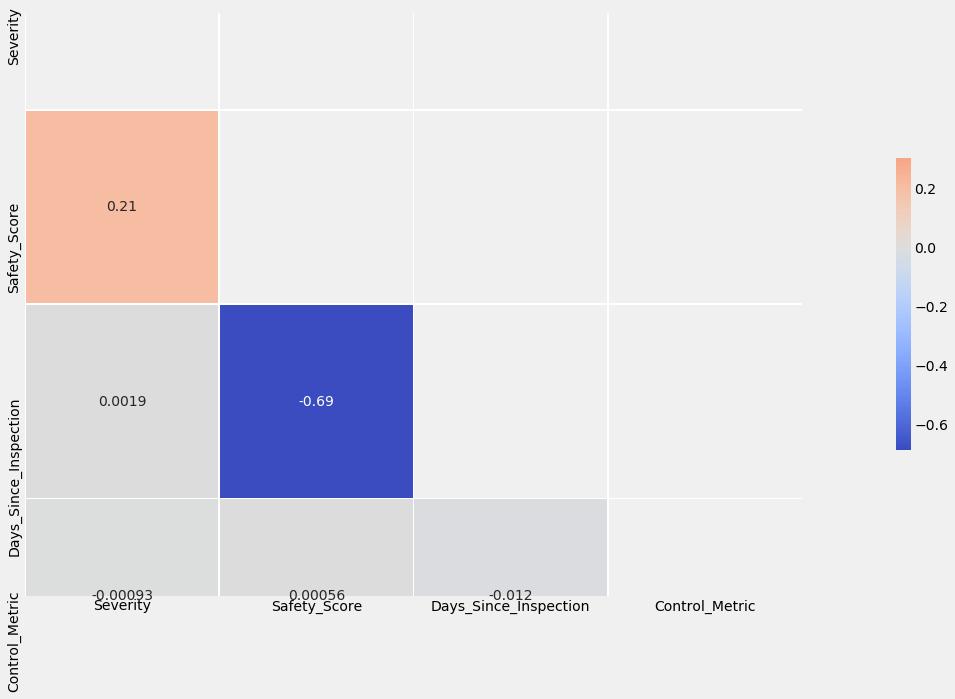

In [60]:
import numpy as np
corr = train.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,cmap = "coolwarm")

In [61]:
target="Severity"
feat= train.columns.tolist()
feat.remove(target)
print("Feature Length : {}".format(len(feat)))

Feature Length : 3


In [62]:
X,y=train.drop(target,axis=1),train[target]
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state = 1994)

In [63]:
X_train.head()

,Safety_Score,Days_Since_Inspection,Control_Metric
Accident_ID,,,
9680,66.255708,12,62.306290
4619,52.557078,13,58.021878
8065,36.849315,14,55.241568
5431,44.018265,15,67.684594
9497,49.178082,14,59.981768


In [64]:
y_train.head()

Accident_ID
9680    2
4619    1
8065    1
5431    1
9497    1
Name: Severity, dtype: int64

In [65]:
y_val.head()

Accident_ID
6013    3
7549    3
6363    0
9197    0
4963    1
Name: Severity, dtype: int64

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_val)
X_final = sc.transform(X.copy())

In [66]:
def baseliner(X_data, y_data, scoring='accuracy', cv=3, Z=2):
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        KNeighborsClassifier(),
        lgb.LGBMClassifier(), ExtraTreesClassifier(), xgb.XGBClassifier(objective='binary:logistic'), 
        cat.CatBoostClassifier(verbose=0), GradientBoostingClassifier(), RandomForestClassifier(), 
        LogisticRegression(), DecisionTreeClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), 
        BaggingClassifier()
        ] #SVR(), 

    print("sklearn Model Name  \t  CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        
    
        classes = y_data.unique()
    
    # Execute Cross Validation
        results = cross_val_score(estimator=model, X=X_data, y=y_data, cv=5, scoring=scoring)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

In [67]:
baseliner(X_data=X, y_data=y, cv=5)

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
KNeighborsClassifier 	 0.9358 	
LGBMClassifier 	 0.9560 	
ExtraTreesClassifier 	 0.9583 	
XGBClassifier 	 0.8835 	
<catboost.core.CatBoo 	 0.9513 	
GradientBoostingClass 	 0.9064 	
RandomForestClassifie 	 0.9608 	
LogisticRegression 	 0.5552 	
DecisionTreeClassifie 	 0.9573 	
ExtraTreeClassifier 	 0.9026 	
AdaBoostClassifier 	 0.4685 	
BaggingClassifier 	 0.9610 	


In [ ]:
param_grid={'n_estimators':[500,1000,2500,5000,10000],
            'learning_rate': [0.1 , 0.05, 0.02, 0.01],
            'max_depth':[6,4,6],
            'min_samples_leaf':[3,5,9,17],
            'max_features':[1.0,0.3,0.1] 
           }
estimator = GradientBoostingClassifier() 
#cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
classifier = GridSearchCV(estimator=estimator, cv=5, param_grid=param_grid, n_jobs=-1) #
classifier.fit(X, y)
print ("Best Estimator learned through GridSearch") 
print (classifier.best_estimator_ )
print(classifier.best_params_)
#return cv, classifier.best_estimator_

In [83]:
model=lgb.LGBMClassifier()
model.fit(X_train,y_train)

predict = model.predict(X_val)
print(model)
#print('Predicted Values on Test Data',encode.inverse_transform(predict))

#print('\n\nAccuracy Score on test data : \n\n')
print(f1_score(y_val,predict,average='weighted'))

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                              

In [69]:
model.fit(X,y)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=train[feat].columns)
feat_importances.nlargest(20).plot(kind='barh')

In [42]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
clf =lgb.LGBMClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.03, 0.01,0.05, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [100,200,500,1000,1500,2000,2500,3000]}

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

random_search = RandomizedSearchCV(clf, param_grid, n_iter=20,cv=5,iid=False,random_state=42)

In [ ]:
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 20))
report(random_search.cv_results_)

best_score = random_search.best_score_
best_params = random_search.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):    
    print('%s: %r' % (param_name, best_params[param_name]))

In [ ]:
model = lgb.LGBMClassifier(colsample_bytree= 0.7,gamma=0.25,learning_rate= 0.3,max_depth= 10,n_estimators= 2500,silent=False,subsample= 0.8)

In [ ]:
model = lgb.LGBMClassifier(colsample_bytree= 0.8,gamma=1.0,learning_rate= 0.03,max_depth= 10,n_estimators= 1500,silent=False,subsample= 0.7)
#best till now

In [ ]:
model = lgb.LGBMClassifier(colsample_bytree= 1.0,gamma=0.25,learning_rate= 0.3,max_depth= 20,n_estimators= 200,silent=False,subsample= 0.5)

In [ ]:
#test_scaled=sc.transform(test)

In [ ]:
test.head()

In [71]:
pred=model.predict(test)
pred

array([0, 2, 3, ..., 3, 3, 0])

In [72]:

unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))

{0: 765, 1: 673, 2: 407, 3: 655}

In [ ]:
'''pred1=pred
pred=[]
for i in pred1:
    pred.append(i[0])
   '''

In [73]:
# load loan_id of test dataset
test_id = pd.read_csv('data/test.csv')['Accident_ID']
print(test_id.shape)

(2500,)


In [74]:
submit = pd.DataFrame({'Accident_ID': test_id, 'Severity': pred})
submit = submit[['Accident_ID','Severity']]  

In [75]:
ord1dict = {1:"Minor_Damage_And_Injuries", 2:"Significant_Damage_And_Fatalities",3: "Significant_Damage_And_Serious_Injuries",0:"Highly_Fatal_And_Damaging"}
submit['Severity'] = submit['Severity'].map(ord1dict)

In [76]:
submit.to_csv("new.csv", index=False)

In [77]:
submit.head()

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Minor_Damage_And_Injuries
4,21,Significant_Damage_And_Fatalities
